In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data_only_excess.csv")

In [3]:
out_path = "./img1/"

In [4]:
# ---- Seleziona colonne XS1..XS10 ----
xs_cols = [c for c in df.columns if c.upper().startswith("XS")]
xs_cols = sorted(xs_cols, key=lambda x: int(''.join(filter(str.isdigit, x))))

In [5]:
def sharpe_monthly(s):
    s = s.dropna()
    sd = s.std(ddof=1)
    return np.nan if sd == 0 else s.mean() / sd

def sharpe_annual(s):
    sm = sharpe_monthly(s)
    return np.sqrt(12) * sm if pd.notna(sm) else np.nan

In [126]:
stats = []
for c in xs_cols:
    s = df[c].dropna()
    stats.append({
        "Portfolio": c,
        "Mean": s.mean(),
        "Std": s.std(ddof=1),
        "Min": s.min(),
        "P25": s.quantile(0.25),
        "Median": s.median(),
        "P75": s.quantile(0.75),
        "Max": s.max(),
        "Skewness": s.skew(),
        "Kurtosis": s.kurt(),      # excess kurtosis
        "Sharpe_ann": ( s.mean() / s.std(ddof=1) ) * np.sqrt(12)
    })

summary = pd.DataFrame(stats).set_index("Portfolio")

In [127]:
summary

,Mean,Std,Min,P25,Median,P75,Max,Skewness,Kurtosis,Sharpe_ann
Portfolio,,,,,,,,,,
XS1,0.010881,0.054137,-0.183606,-0.020693,0.009738,0.037850,0.272537,0.485788,3.499482,0.696228
XS2,0.010486,0.055256,-0.212679,-0.017454,0.011307,0.039881,0.268165,-0.039028,3.007238,0.657409
XS3,0.008679,0.053735,-0.245850,-0.017188,0.010675,0.041357,0.292786,-0.270270,4.144407,0.559521
XS4,0.007937,0.055451,-0.226760,-0.020745,0.009293,0.037425,0.257831,-0.195569,3.076267,0.495844
XS5,0.007213,0.054870,-0.232751,-0.019079,0.010068,0.036271,0.231386,-0.294221,2.407708,0.455368
XS6,0.007588,0.054640,-0.243137,-0.020099,0.011450,0.036424,0.231816,-0.516448,2.655642,0.481073
XS7,0.006724,0.054485,-0.247386,-0.019320,0.010202,0.036103,0.220583,-0.773752,3.274484,0.427533
XS8,0.006622,0.054451,-0.262396,-0.019357,0.013687,0.038953,0.194203,-1.020210,3.630051,0.421257
XS9,0.006735,0.055294,-0.293794,-0.022260,0.013866,0.040621,0.154779,-0.936429,3.112148,0.421941


In [82]:
# Helper per il grafico mean ± 1 std + min–max + mean point 
def plot_mean_std_minmax(xs_labels, means, stds, mins, maxs, title, fname=None): 
    x = np.arange(len(xs_labels)) 
    plt.figure(figsize=(8,5)) 
    # barra semitrasparente mean ± 1 std 
    plt.bar(x, 2*stds, bottom=means-stds, width=0.6, alpha=0.3, color='skyblue', label='±1 Std')
    
    # min–max con “stanghette”
    yerr = [means - mins, maxs - means] 
    
    plt.errorbar(x, means, yerr=yerr, fmt='none', ecolor='gray', elinewidth=1, capsize=5, capthick=1, label='Min–Max') 
    
    # punto media 
    plt.scatter(x, means, color='black', s=5, zorder=3, label='Mean')
    
    for i, m in enumerate(means):
        plt.text(
            x[i],
            m + stds[i]*0.1,             # posizionata poco sopra la media
            f"{m*100:.2f}%",              # formato percentuale
            ha='center', va='bottom',
            fontsize=6, color='black',
            bbox=dict(facecolor='white', edgecolor='none', pad=0.8, alpha=0.9)
        )
    
    plt.xticks(x, xs_labels) 
    plt.ylabel("Monthly excess return") 
    plt.title(title) 
    plt.legend(frameon=False, loc='upper right', bbox_to_anchor=(1, 1.02)) 
    plt.grid(axis='y', linestyle=':', alpha=0.4) 
    plt.tight_layout() 
    if fname: 
        plt.savefig(f"{out_path}{fname}", dpi=300, bbox_inches='tight') 
    plt.show()

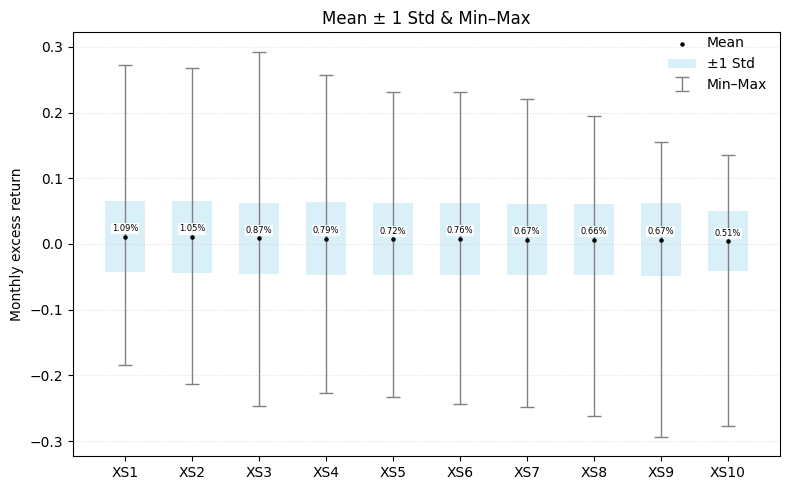

In [83]:
means = df[xs_cols].mean().values
stds  = df[xs_cols].std(ddof=1).values
mins  = df[xs_cols].min().values
maxs  = df[xs_cols].max().values
plot_mean_std_minmax(xs_cols, means, stds, mins, maxs, title="Mean ± 1 Std & Min–Max", fname="mean_std_minmax.png")

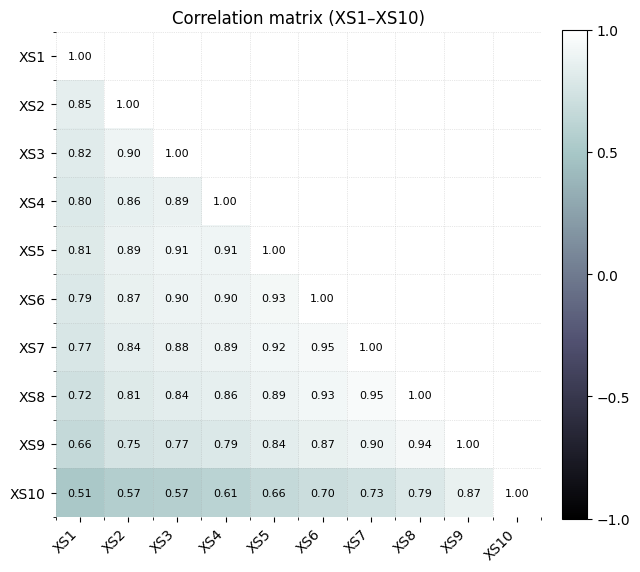

In [10]:
corr = df[xs_cols].corr().reindex(index=xs_cols, columns=xs_cols)

# Maschera triangolo superiore
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
data = np.ma.masked_where(mask, corr.values)

plt.figure(figsize=(6.5, 6.0))

# Heatmap sobria con scala fissa [-1, 1]
im = plt.imshow(data, vmin=-1, vmax=1, cmap="bone", aspect='equal')

# Colorbar compatta
cbar = plt.colorbar(im, fraction=0.046, pad=0.04)
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])

# Tick e griglia sottile
plt.xticks(np.arange(len(xs_cols)), xs_cols, rotation=45, ha='right')
plt.yticks(np.arange(len(xs_cols)), xs_cols)
plt.gca().set_xticks(np.arange(-.5, len(xs_cols), 1), minor=True)
plt.gca().set_yticks(np.arange(-.5, len(xs_cols), 1), minor=True)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.6)
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Etichette numeriche dentro le celle (uniformi)
for i in range(len(xs_cols)):
    for j in range(len(xs_cols)):
        if not mask[i, j]:  # solo parte inferiore
            val = corr.values[i, j]
            plt.text(j, i, f"{val:.2f}", ha='center', va='center', fontsize=8, color='black')

plt.title("Correlation matrix (XS1–XS10)")
plt.tight_layout()

plt.savefig(f"{out_path}corr_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

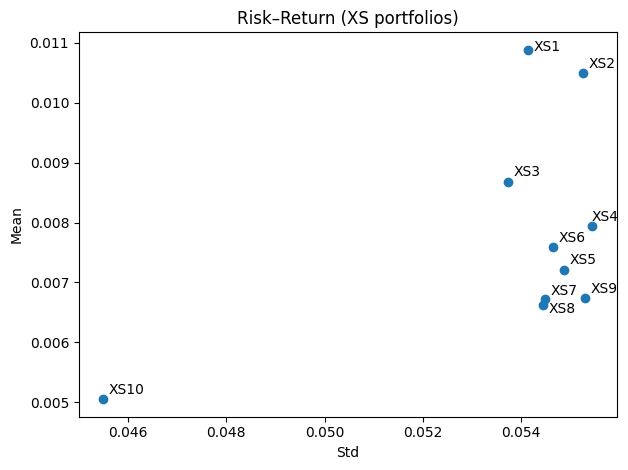

In [134]:
means = df[xs_cols].mean(); stds = df[xs_cols].std(ddof=1)
plt.figure()
plt.scatter(stds, means)
for c in xs_cols:
    x_val, y_val = stds[c], means[c]
    dx, dy = 4, 4  # offset base
    if c == "XS1": dy = -1  # sposta XS1 un po' più in basso
    if c == "XS4": dx = -1  # sposta XS4 un po' più a destra
    if c == "XS7": dy = 3  # sposta XS7 un po' più in alto
    if c == "XS8": dy = -6 # sposta XS8 un po' più in basso
    plt.annotate(c, (x_val, y_val), xytext=(dx,dy), textcoords="offset points")

plt.xlabel("Std"); plt.ylabel("Mean"); plt.title("Risk–Return (XS portfolios)")
plt.tight_layout()
plt.savefig(f"{out_path}risk-return.png", dpi=300, bbox_inches="tight")
plt.show()

In [136]:
def plot_outliers_grid(df, xs_cols, out_path="", mode="sigma", thresh=3, limits=(0.01, 0.01)):

    fig, axes = plt.subplots(2, 5, figsize=(14, 6), sharex=False, sharey=False)
    axes = axes.ravel()

    # suptitle text
    if mode == "sigma":
        sup_txt = f"Outlier detection (|z| > {thresh})"
    else:
        lpc, hpc = int(limits[0]*100), 100 - int(limits[1]*100)
        sup_txt = f"Outlier detection ({lpc}th–{hpc}th percentiles)"

    for ax, c in zip(axes, xs_cols):
        s = df[c].dropna()

        # asse X: date se presenti, altrimenti indice numerico (identico al tuo)
        xvals = s.index if isinstance(df.index, np.ndarray.__class__(np.datetime64)) or isinstance(df.index, type(df.index)) and hasattr(df.index, 'inferred_type') and df.index.inferred_type == 'datetime64' \
                else (s.index if isinstance(df.index, (pd.DatetimeIndex,)) else np.arange(len(s)))
        # se vuoi forzare indice numerico: xvals = np.arange(len(s))
        # oppure date da colonna: xvals = df.loc[s.index, "date"]

        if mode == "sigma":
            mu, sd = s.mean(), s.std(ddof=1)
            z = (s - mu) / sd
            out = z.abs() > thresh
            low, high = mu - thresh*sd, mu + thresh*sd
        else:
            low = s.quantile(limits[0])
            high = s.quantile(1 - limits[1])
            out = (s < low) | (s > high)

        # scatter identico
        ax.scatter(xvals, s, s=8, alpha=0.6, label="Normal")
        ax.scatter(xvals[out], s[out], s=14, color="red", label="Outliers", zorder=3)

        # soglie tratteggiate identiche
        ax.axhline(high, linestyle="--", linewidth=0.8)
        ax.axhline(low,  linestyle="--", linewidth=0.8)

        ax.set_title(c, fontsize=9)
        if isinstance(df.index, pd.DatetimeIndex):
            ax.tick_params(axis="x", labelrotation=45)

    # legenda sotto il titolo (identica)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.suptitle(sup_txt, y=0.99, fontsize=12)
    fig.legend(handles, labels,
               loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 0.965))

    # layout e salvataggio (identici)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    tag = "z{}".format(thresh) if mode == "sigma" else f"pct{int(limits[0]*100)}_{int(limits[1]*100)}"
    plt.savefig(f"{out_path}outliers_grid_{tag}.png", dpi=300, bbox_inches="tight")
    plt.show()

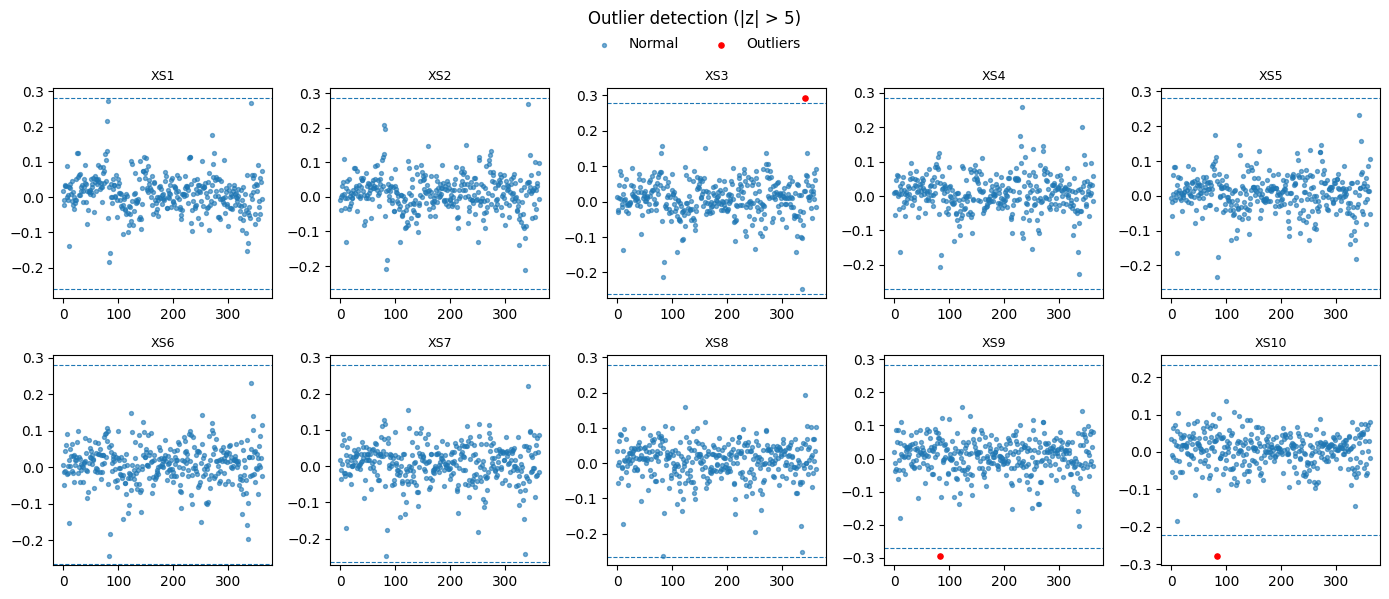

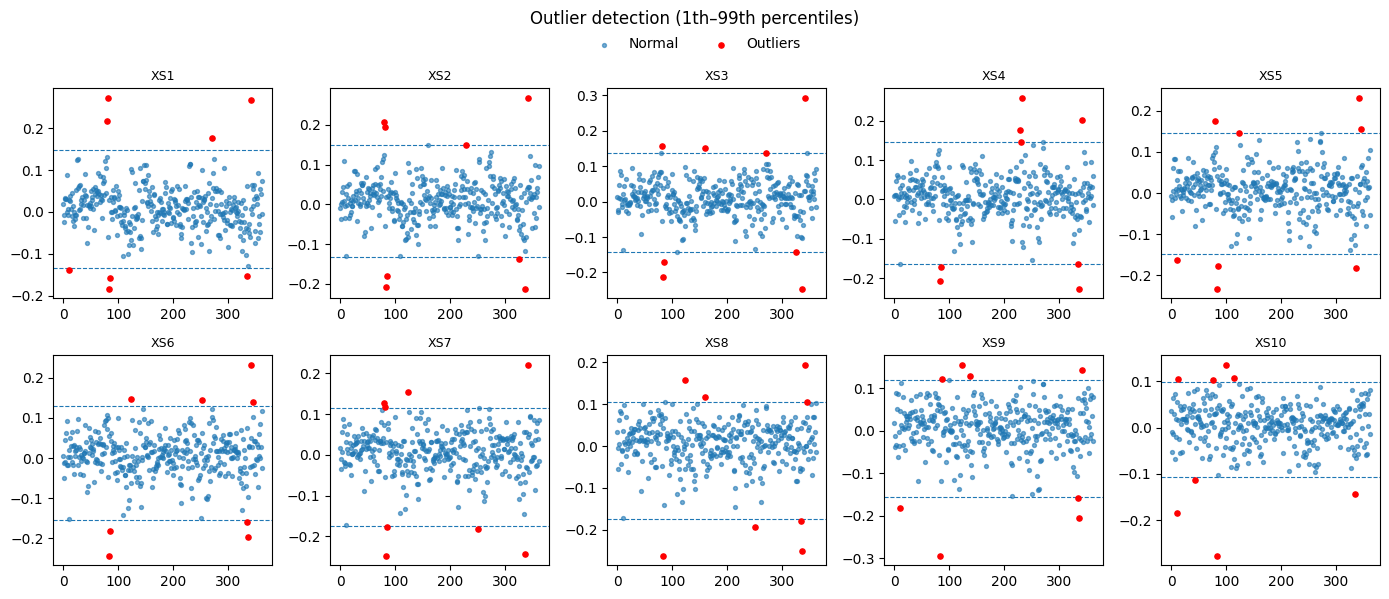

In [137]:
plot_outliers_grid(df, xs_cols, out_path="img1/", mode="sigma", thresh=5)
plot_outliers_grid(df, xs_cols, out_path="img1/", mode="percentile", limits=(0.01, 0.01))

In [14]:

# === CONFIG: scegli il metodo di winsorization ===
WINSOR_MODE = "sigma"          # "sigma" oppure "percentile"
THRESH = 5                     # valido se WINSOR_MODE == "sigma"
LIMITS = (0.01, 0.01)          # (low, high) frazioni; valido se "percentile" (es. 1% e 1%)

# Helper per statistiche
def get_stats(frame, cols):
    means = frame[cols].mean().values
    stds  = frame[cols].std(ddof=1).values
    mins  = frame[cols].min().values
    maxs  = frame[cols].max().values
    return means, stds, mins, maxs

# --- Funzione winsorization: σ-based o percentile-based ---
def winsorize_series(s, mode=WINSOR_MODE, k=THRESH, limits=LIMITS):
    s = s.astype(float)
    if mode == "sigma":
        mu = s.mean()
        sd = s.std(ddof=1)
        low, high = mu - k*sd, mu + k*sd
    elif mode == "percentile":
        low = s.quantile(limits[0])
        high = s.quantile(1 - limits[1])
    else:
        raise ValueError("WINSOR_MODE must be 'sigma' or 'percentile'.")
    return s.clip(lower=low, upper=high)

# --- Crea versione winsorizzata (colonne *_W) ---
df_w = df.copy()
for c in xs_cols:
    df_w[c + "_W"] = winsorize_series(df[c])

# --- Stats helper come prima (riusiamo il tuo) ---
means_o, stds_o, mins_o, maxs_o = get_stats(df, xs_cols)
means_w, stds_w, mins_w, maxs_w = get_stats(df_w, [c + "_W" for c in xs_cols])

# --- Titolo per il grafico winsorizzato, in base al metodo scelto ---
if WINSOR_MODE == "sigma":
    w_title = f"winsorized at ±{THRESH}σ"
else:
    lowp = int(LIMITS[0]*100)
    highp = 100 - int(LIMITS[1]*100)
    w_title = f"winsorized at {lowp}th–{highp}th percentiles"

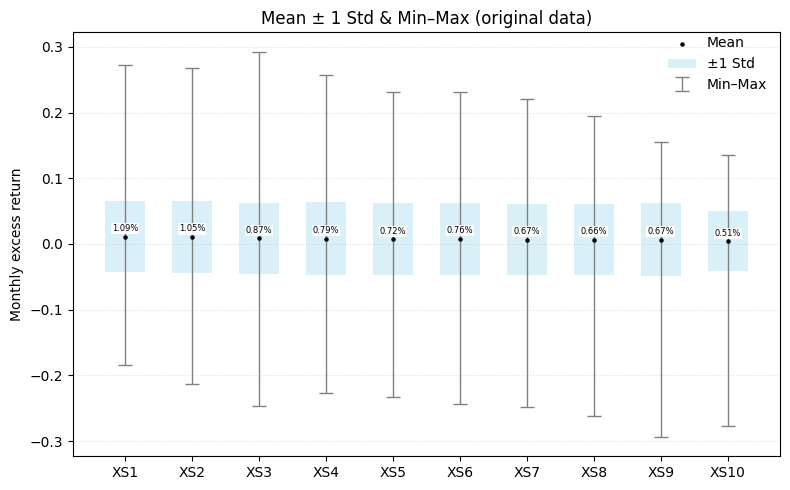

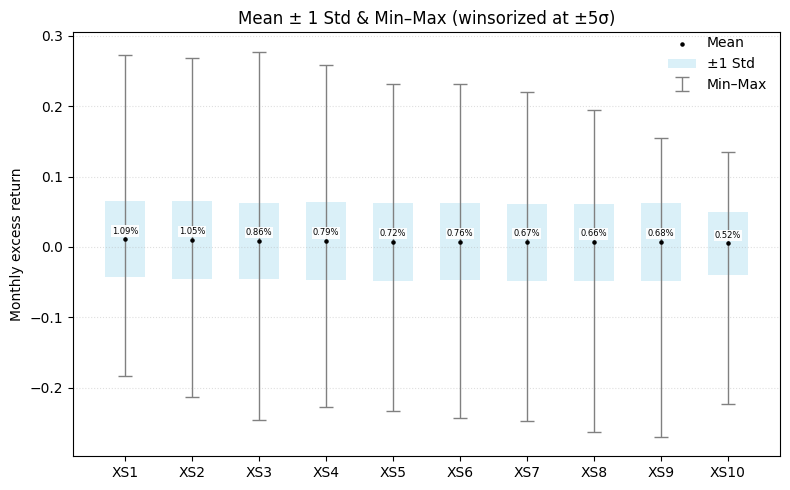

In [84]:
# Plot: originale
plot_mean_std_minmax(xs_cols, means_o, stds_o, mins_o, maxs_o, title="Mean ± 1 Std & Min–Max (original data)")

# Plot: winsorizzato (titolo automatico in base al metodo)
plot_mean_std_minmax(xs_cols, means_w, stds_w, mins_w, maxs_w, title=f"Mean ± 1 Std & Min–Max ({w_title})", fname="mean_std_minmax_winsorized.png")

In [17]:
delta = pd.DataFrame({
    "Mean_orig": means_o, "Mean_winsor": means_w, "ΔMean": means_w - means_o,
    "Std_orig": stds_o,   "Std_winsor": stds_w,   "ΔStd":  stds_w - stds_o
}, index=xs_cols).round(6)

print(f"\nChanges after winsorization ({w_title})")
print(delta)


Changes after winsorization (winsorized at ±5σ)
      Mean_orig  Mean_winsor     ΔMean  Std_orig  Std_winsor      ΔStd
XS1    0.010881     0.010881  0.000000  0.054137    0.054137  0.000000
XS2    0.010486     0.010486  0.000000  0.055256    0.055256  0.000000
XS3    0.008679     0.008637 -0.000043  0.053735    0.053516 -0.000220
XS4    0.007937     0.007937  0.000000  0.055451    0.055451  0.000000
XS5    0.007213     0.007213  0.000000  0.054870    0.054870  0.000000
XS6    0.007588     0.007588  0.000000  0.054640    0.054640  0.000000
XS7    0.006724     0.006724  0.000000  0.054485    0.054485  0.000000
XS8    0.006622     0.006622  0.000000  0.054451    0.054451  0.000000
XS9    0.006735     0.006801  0.000066  0.055294    0.054946 -0.000348
XS10   0.005052     0.005203  0.000150  0.045496    0.044644 -0.000852


In [19]:
df_w.to_csv( "data_W.csv", index=False )

In [128]:
def format_summary_for_table(summary: 'pd.DataFrame'):
    """Ritorna (columns, index, cell_text) formattati per la tabella."""
    df = summary.copy()

    # Se ci sono queste colonne, converto in percentuale
    pct_cols = [c for c in ["Mean", "Std", "Min", "P25", "Median", "P75", "Max"] if c in df.columns]
    for c in pct_cols:
        df[c] = (df[c] * 100).map(lambda v: f"{v:.2f}%")

    # Sharpe: decimali classici
    for c in ["Sharpe_m", "Sharpe_ann"]:
        if c in df.columns:
            df[c] = df[c].map(lambda v: f"{v:.2f}")

    # Skew/Kurtosis
    for c in ["Skewness", "Kurtosis", "Count"]:
        if c in df.columns:
            if c == "Count":
                df[c] = df[c].astype(int).astype(str)
            else:
                df[c] = df[c].map(lambda v: f"{float(v):.2f}")

    cols = list(df.columns)
    idx  = list(df.index)
    cell_text = df.values.tolist()
    return cols, idx, cell_text

def render_summary_table_png(summary, filename="./img1/summary_table.png", row_scale=1.2, wide_first_n=7, wide_factor=1.45 ):
    """
    Disegna una tabella con matplotlib, con header e celle centrati,
    zebra-striping e salvataggio PNG.
    """
    cols, idx, cell_text = format_summary_for_table(summary)

    n_rows, n_cols = len(idx), len(cols)

    # figure un po' più larga per lasciare spazio ai colWidths
    fig_w = max(9, n_cols * 1.05)
    fig_h = max(2.8, n_rows * 0.46 + 0.8)

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.axis("off")

    # --- colWidths espliciti: [rowLabels, col0, col1, ...] come frazioni dell'axes
    base = 1.0 / (n_cols + 1)  # +1 per colonna delle row labels
    col_widths = [base * 1.25]  # row labels un filo più larga
    for j in range(n_cols):
        if j < wide_first_n:
            col_widths.append(base * wide_factor)
        else:
            col_widths.append(base * 1.00)

    # crea tabella con bbox pieno (così i colWidths contano davvero)
    tbl = ax.table(cellText=cell_text, rowLabels=idx, colLabels=cols,
                   cellLoc='center', loc='center', colWidths=col_widths, bbox=[0,0,1,1])

    # stile celle (header + zebra)
    for (r, c), cell in tbl.get_celld().items():
        if r == 0:
            cell.set_facecolor("#E9EEF7")
            cell.set_edgecolor("#D0D7E2")
            cell.get_text().set_weight('bold')
            cell.get_text().set_ha('center'); cell.get_text().set_va('center')
        else:
            cell.set_edgecolor("#E6ECF2")
            cell.set_facecolor("#FBFCFE" if (r % 2)==0 else "#F4F7FB")
            cell.get_text().set_ha('center'); cell.get_text().set_va('center')

    # font e altezza righe
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(9)
    tbl.scale(1.0, row_scale)

    # --- forzatura finale delle larghezze per ogni colonna effettiva (workaround robusto)
    # mappa col_index -> width dalla nostra lista col_widths
    # (0 = row labels; 1..n_cols = colonne dati)
    cols_present = sorted({c for (_, c) in tbl.get_celld().keys()})
    width_map = {c: col_widths[c] for c in cols_present if c < len(col_widths)}
    for (r, c), cell in tbl.get_celld().items():
        if c in width_map:
            cell.set_width(width_map[c])

    # niente titolo, solo tabella
    fig.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02)
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {filename}")

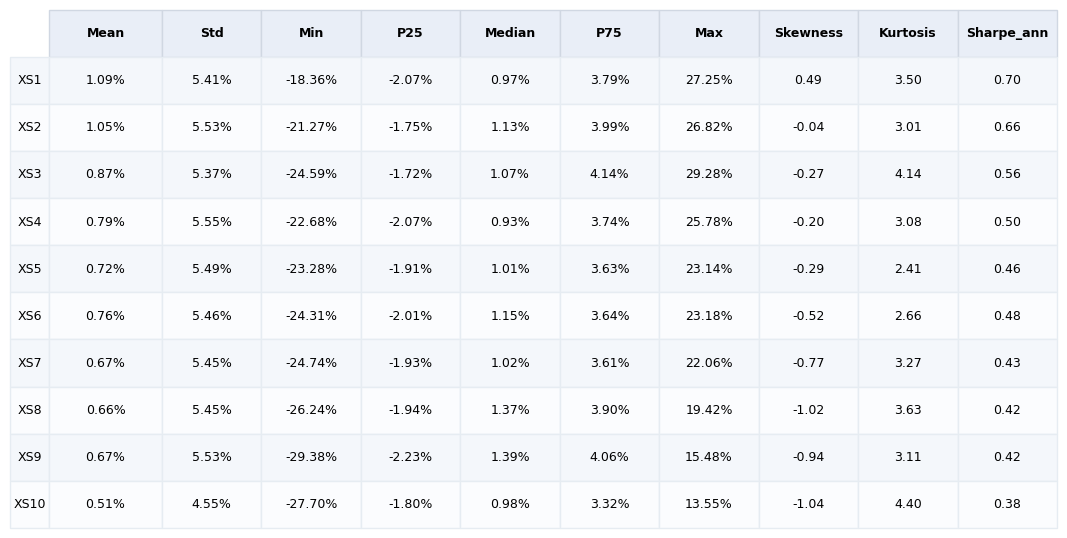

Saved: ./img1/summary_stats.png


In [129]:
render_summary_table_png(summary, filename="./img1/summary_stats.png", row_scale=1.18, wide_first_n=11, wide_factor=1.1)

The dataset includes monthly excess returns (over the risk-free rate) for ten portfolios of UK equities (XS1–XS10), sorted by market capitalization.
The goal of this first stage was to inspect the data, identify potential outliers, and summarize the main statistical properties of the series.

The summary statistics table reports, for each portfolio (XS1–XS10), the mean, standard deviation, minimum, maximum, quantiles (25%, median, and 75%), skewness, kurtosis (excess kurtosis relative to the normal distribution), and both monthly and annualized Sharpe ratios.
The quantiles describe the internal dispersion of returns, while the Sharpe ratio measures the risk-adjusted performance of each portfolio.
Positive skewness indicates that large positive returns are more frequent than large negative ones, and high kurtosis suggests heavy tails, meaning that extreme observations occur more often than in a normal distribution.

The descriptive statistics table shows that average returns gradually decrease from XS1 (small-cap stocks) to XS10 (large-cap stocks), while volatility (standard deviation) is higher for the smaller portfolios.
This pattern confirms the typical size effect: small-cap firms exhibit higher average returns but also greater risk.
Most return distributions display positive skewness and high kurtosis, indicating heavy tails and a higher frequency of extreme monthly observations.

The “Mean ± 1 Std” chart effectively summarizes this behavior: wider blue bars for XS1–XS3 highlight greater variability, whereas the black dots (means) show a downward trend in average returns as portfolio size increases.
The grey lines represent total ranges (min–max), which shrink considerably for large-cap portfolios.
The correlation matrix reveals strong positive correlations among all portfolios, particularly between adjacent size groups, reflecting their common exposure to broad market factors.

Outliers were detected using the Z-score method (|z| > 3). These extreme observations, often linked to market shocks, were subsequently treated through winsorization, replacing values beyond the threshold with the corresponding boundary value.
Comparing the “Mean ± 1 Std” graphs before and after winsorization shows minimal changes in means but a slight reduction in standard deviations—mainly for small-cap portfolios—indicating that outliers had limited impact on overall risk–return patterns.


In summary:
1) Average returns decline with portfolio size.
2) Volatility is higher for smaller portfolios.
3) Portfolios are highly correlated with one another.
4) Winsorization reduces dispersion slightly but does not alter the main conclusions.